## Rossmann Data Exploratory Analysis

Goal: Explore data and predict 6 weeks of daily sales for 1,115 stores located across Germany.

See more detail [kaggle](https://www.kaggle.com/c/rossmann-store-sales)

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from pandas import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# statistics
from statsmodels.distributions.empirical_distribution import ECDF
# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


In [2]:
store = pd.read_csv("store.csv",low_memory=False)
# analysis data through time series
train = pd.read_csv("train.csv",parse_dates=True,low_memory=False,index_col="Date")

In [3]:
store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [4]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [5]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


In [6]:
train.index

DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None)

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 8 columns):
Store            1017209 non-null int64
DayOfWeek        1017209 non-null int64
Sales            1017209 non-null int64
Customers        1017209 non-null int64
Open             1017209 non-null int64
Promo            1017209 non-null int64
StateHoliday     1017209 non-null object
SchoolHoliday    1017209 non-null int64
dtypes: int64(7), object(1)
memory usage: 69.8+ MB


## Exploratory Data Analysis
In this first section we go through the train and store data, handle missing values and create new features for further analysis.

In [8]:
train.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


we are dealing with time series data so it will probably serve us to extract dates for further analysis. We also have two likely correlated variables in the dataset, which can be combined into a new feature

In [9]:
# data extraction
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear

# adding new variable
train['SalePerCustomer'] = train['Sales'] / train['Customers']
train['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

On average customers spend about 9.50$ per day. Though there are days with Sales equal to zero

### ECDF: Empirical Cumulative Distribution Function

To get the first impression about continious variables in the data

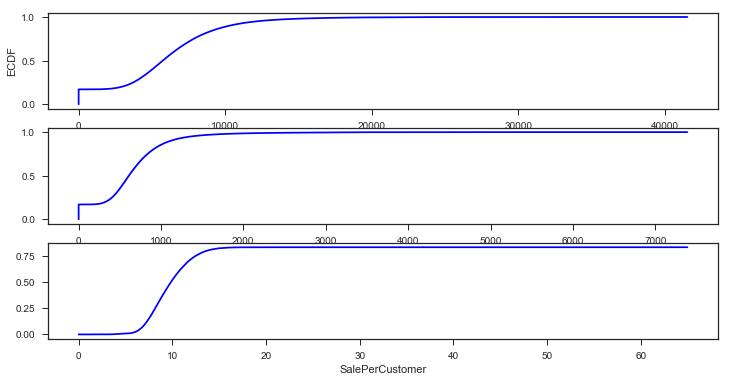

In [10]:
sns.set(style = "ticks")
plt.figure(figsize = (12,6))

plt.subplot(311)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y,color='blue')
plt.xlabel('Sales')
plt.ylabel('ECDF')

plt.subplot(312)
cdf = ECDF(train['Customers'])
plt.plot(cdf.x,cdf.y,color='blue')
plt.xlabel('Customers')

plt.subplot(313)
cdf = ECDF(train['SalePerCustomer'])
plt.plot(cdf.x,cdf.y,color='blue')
plt.xlabel('SalePerCustomer')

We can see, there is about 20% of data has zero amount of sales/customers that we need to deal with and almost 80% of time daily amount of sales was less than 10000. So what about zero sales, is it only due to the fact that the store is closed?

In [11]:
np.where(train.Sales == 0)[0].shape

(172871,)

### filling in missing values

In [12]:
# closed stores
train[(train.Open == 0) & (train.Sales == 0)].shape

(172817, 13)

There are 172817 closed stores in the data. It is about 10% of the total amount of zero sales. To avoid any biased forecasts we will drop these values

In [13]:
# opened stores with zero sales
train[(train.Open != 0) & (train.Sales == 0)].shape

(54, 13)

There are opened store with **no sales on working days.** There are only 54 days in the data, so we can assume that there were external factors involved.

In [14]:
print("Closed stores and days which didn't have any sales won't be counted into the forecasts.")
train = train[(train.Open != 0)&(train.Sales != 0)]
print("In total: ", train.shape)

Closed stores and days which didn't have any sales won't be counted into the forecasts.
In total:  (844338, 13)


In [15]:
# information about store data
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


* Store: a unique Id for each store
* StoreType: differentiates between 4 different store models: a, b, c, d
* Assortment: describes an assortment level: a = basic, b = extra, c = extended
* CompetitionDistance: distance in meters to the nearest competitor store
* CompetitionOpenSince[Month/Year]: gives the approximate year and month of the time the nearest competitor was opened
* Promo2: Promo2 is a continuing a promotion for some stores: 0 = store is not participating, 1 = store is participating
* Promo2Since[Year/Week]: describes the year and calendar week when the store started participating in Promo2
* PromoInterval: describes the consecutive intervals Promo2 is started, naming the months the promotion is started. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [16]:
# missing values
store.isnull().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

In [17]:
# filling in missing values in competitionDistance
# we use the median values to replace NaN
store['CompetitionDistance'].fillna(store['CompetitionDistance'].median(),inplace = True)

Countinuing further with missing data. What about Promo2SinceWeed? May it be that we observe unusual data points?

In [18]:
# no promo = no information about the promo?
_ = store[pd.isnull(store.Promo2SinceWeek)]
_[_.Promo2 != 0].shape

(0, 10)

If there's no promo2 then there's no information about it. We can replace these values by zeros. The same goes for the variables deducted from the competiton, competitionOpenSinceMonth and competitionOpenSinceYear.


In [19]:
# replace NaN by 0
store.fillna(0,inplace = True)

In [20]:
print("Joining train set with an additional store information.")
# by specifying inner join we make sure that only those obsevations that are
# present in both train and store sets are merged together
train_store = pd.merge(train,store,how = 'inner',on = 'Store')
print("In total: ",train_store.shape)
train_store.head()

Joining train set with an additional store information.
In total:  (844338, 22)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,...,SalePerCustomer,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,...,9.482883,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,1,4,5020,546,1,1,0,1,2015,7,...,9.194139,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
2,1,3,4782,523,1,1,0,1,2015,7,...,9.143403,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
3,1,2,5011,560,1,1,0,1,2015,7,...,8.948214,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
4,1,1,6102,612,1,1,0,1,2015,7,...,9.970588,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0


### Store types

In the section we will closely look at different levels of *StoreType* and how the main metric *Sales* is distributed among them.

In [21]:
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,457042.0,6925.697986,3277.351589,46.0,4695.25,6285.0,8406.00,41551.0
b,15560.0,10233.380141,5155.729868,1252.0,6345.75,9130.0,13184.25,38722.0
c,112968.0,6933.126425,2896.958579,133.0,4916.00,6408.0,8349.25,31448.0
d,258768.0,6822.300064,2556.401455,538.0,5050.00,6395.0,8123.25,38037.0


*StoreType* b has the highest average of Sales among all others, however, we have much less data for it. So let's print an overall sum of *Sales and Customers* to see which StoreType is the most selling and croweded one:

In [22]:
train_store.groupby('StoreType')['Customers','Sales'].sum()

,Customers,Sales
StoreType,,
a,363541431,3165334859
b,31465616,159231395
c,92129705,783221426
d,156904995,1765392943


Type A goes on the first place in both Sales and Customers. What about the periods? Seaborn's facet grid is the best tool for this task:


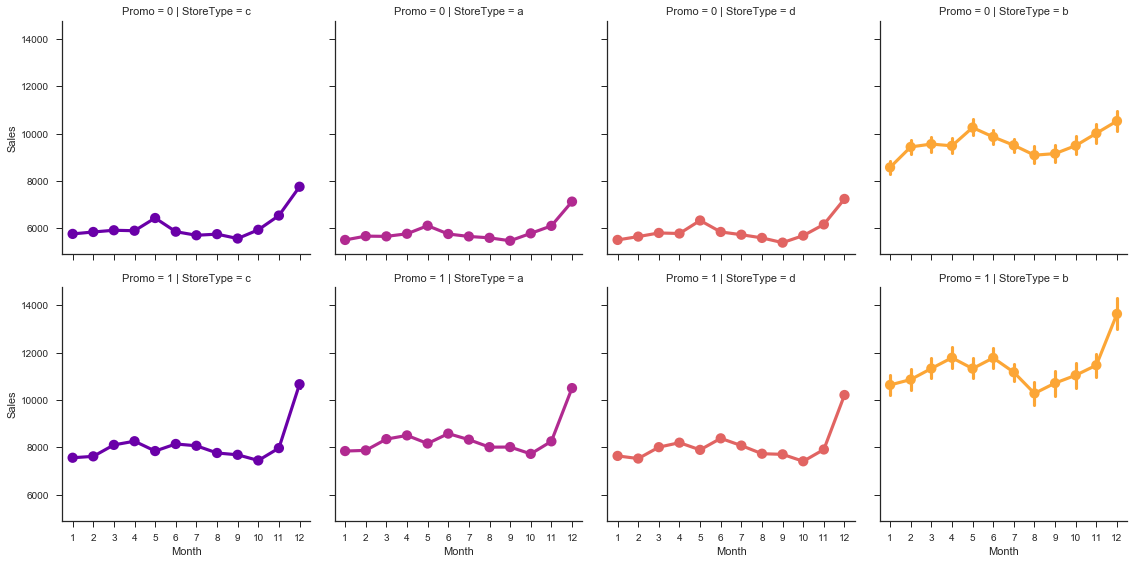

In [23]:
# sales trend
sns.factorplot(data = train_store, x = 'Month', y = 'Sales',
              col = 'StoreType', # per store type in cols
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo',# per promo in the store in rows
              color = 'blue')

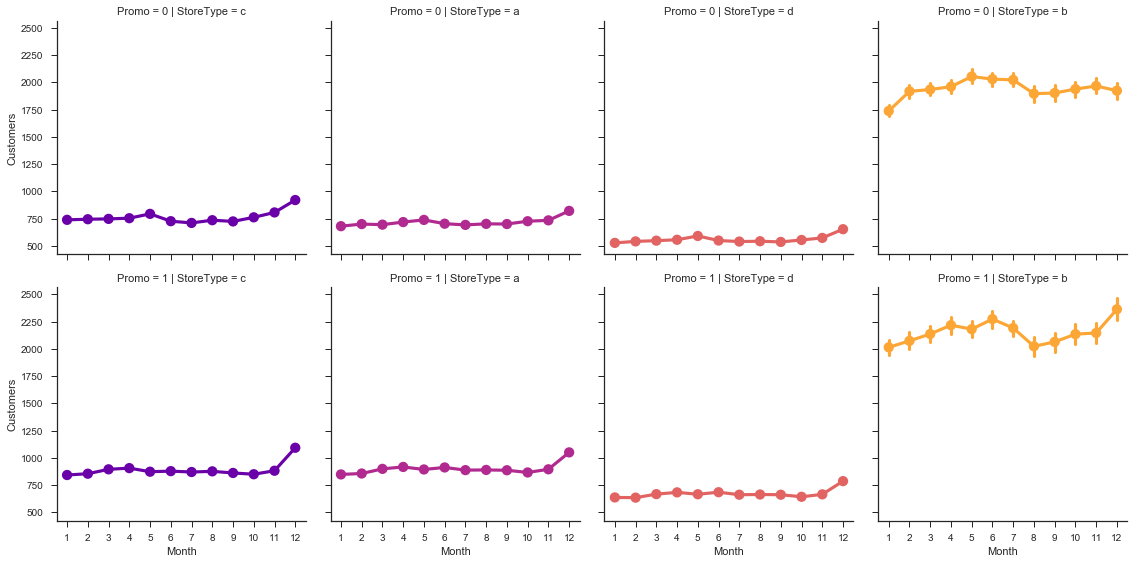

In [24]:
# customers trends
sns.factorplot(data = train_store, x = 'Month', y = 'Customers',
              col = 'StoreType', # per store type in cols
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo',# per promo in the store in rows
              color = 'blue')

All store types follow the same trend but at different scales depending on the presence of the promotion(1) and StoreType(b) itself

**At the same time, we can see that Sales escalate towards Christmas holidays (12). But we will talk about seasonalities and trends later**

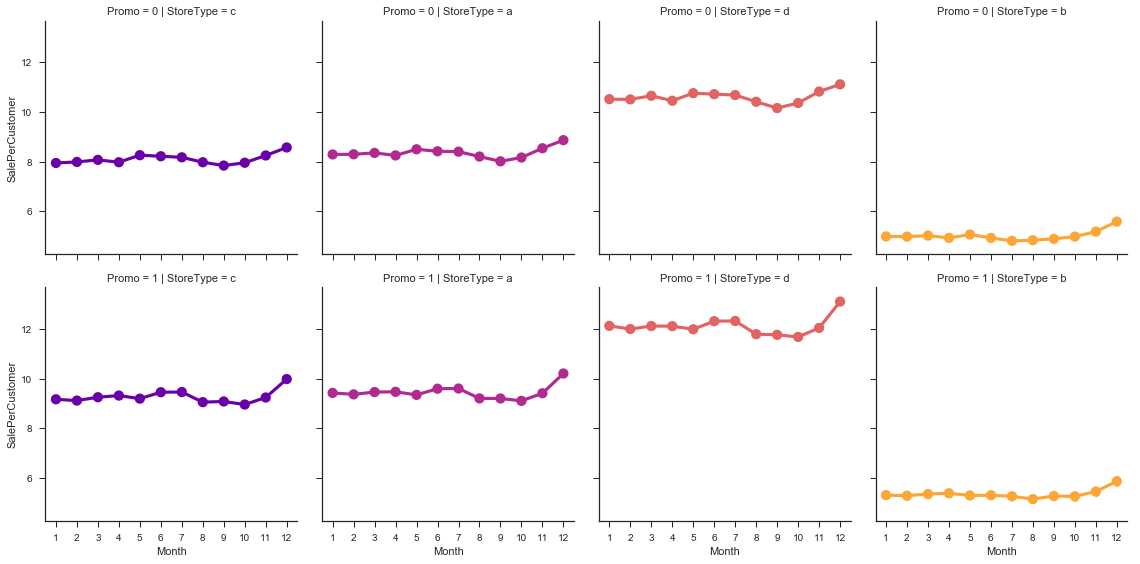

In [25]:
# sale/customer trends
sns.factorplot(data = train_store, x = 'Month', y = 'SalePerCustomer',
              col = 'StoreType', # per store type in cols
              palette = 'plasma',
              hue = 'StoreType',
              row = 'Promo',# per promo in the store in rows
              color = 'blue')

Wow! Eventhough the plots above showed StoreType b as the most selling and performant one, however, in reality it is not true(Through salepercustomer point). The highest SalePerCustomer amount is observed at the type d, about 12\$ with Promo and 10\$ without it. As for StoreType a and c, it is about 9$. d is the lowest.

From Low salepercustomer amount for b, we can guess its Buyer Cart: there are a lot of people who shop essentially for "small" things (or in a little quanlity). Plus we saw that overall this Storetype generated the least amount of sales and customers over the period.

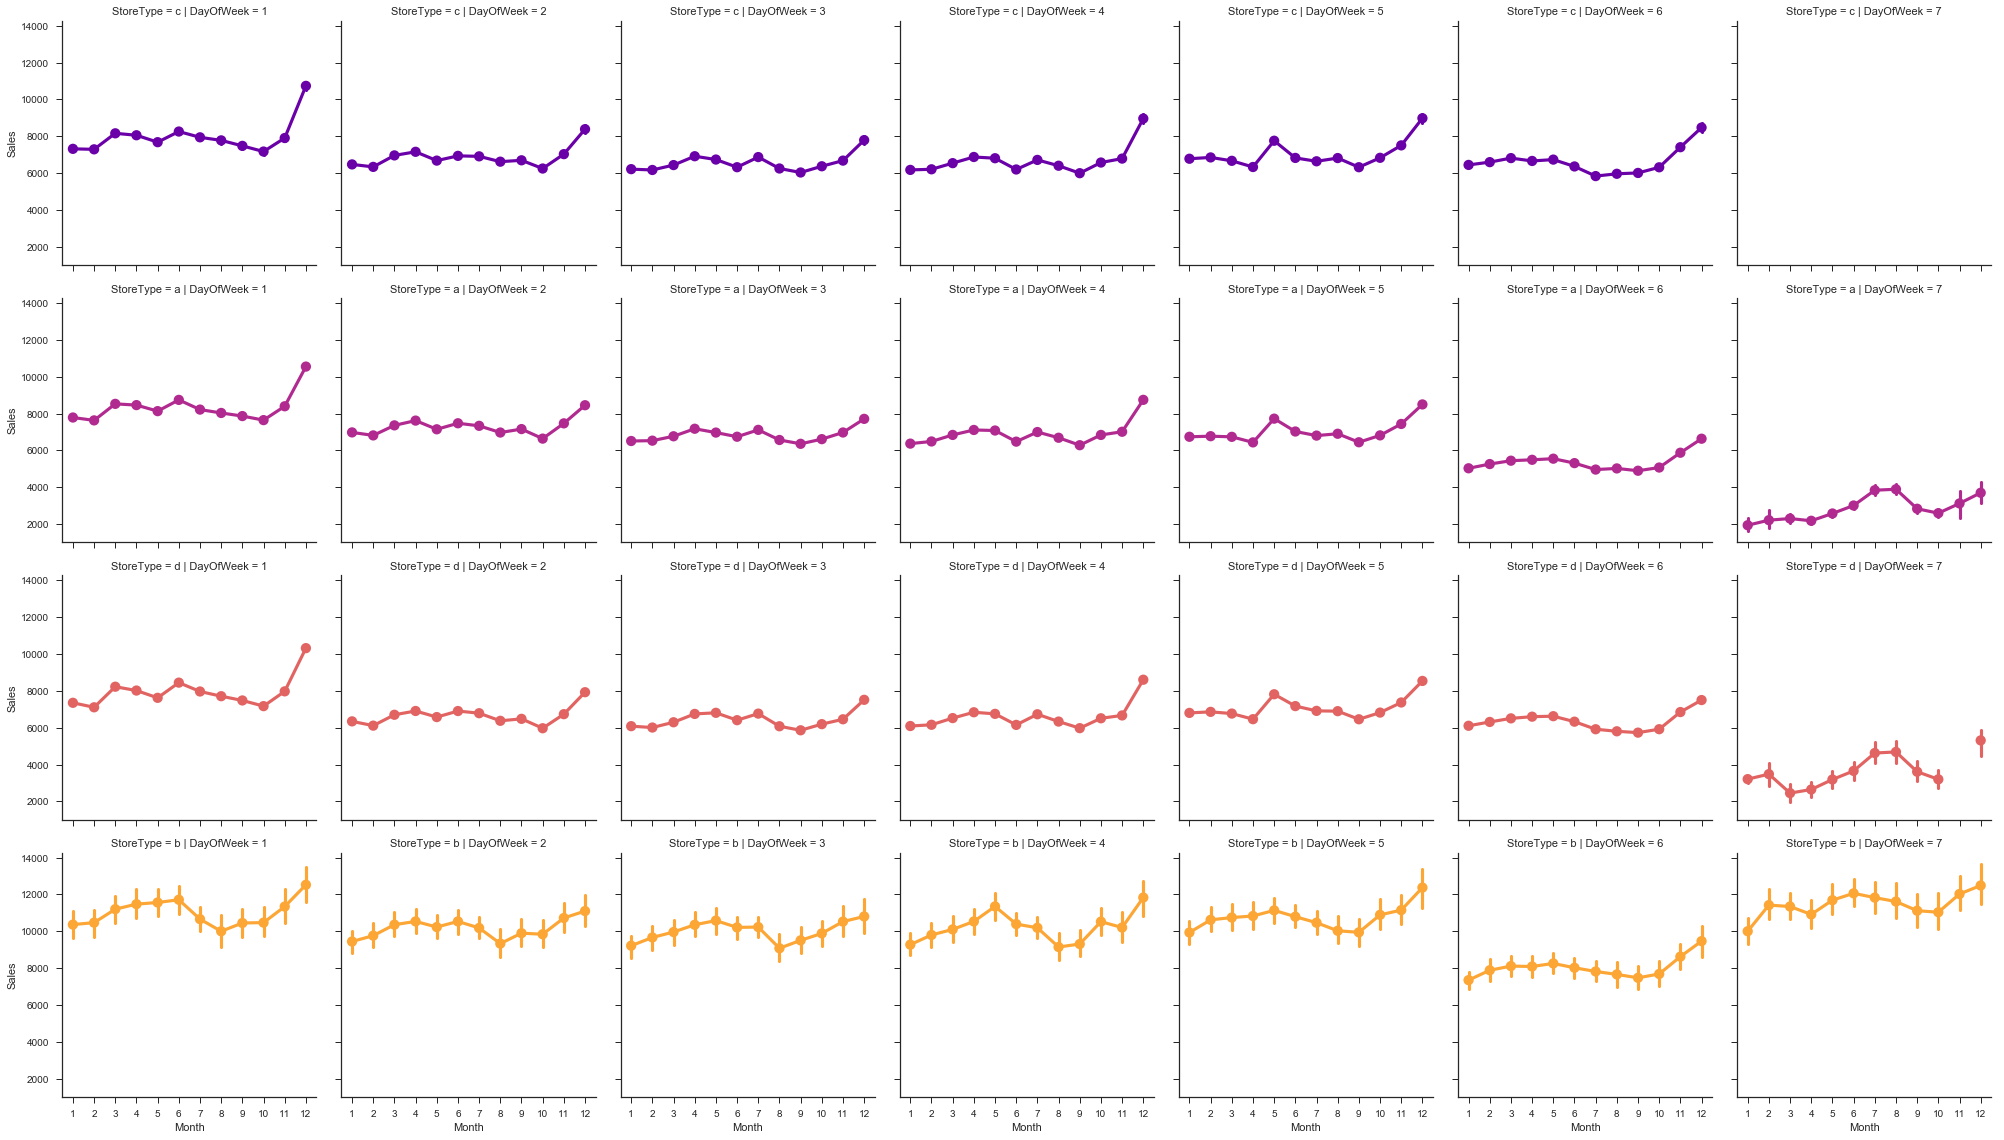

In [26]:
# sales by dayofweek
sns.factorplot(data = train_store, x = 'Month', y = 'Sales',
              col = 'DayOfWeek', # per DayOfWeed type in cols
              palette = 'plasma',
              hue = 'StoreType',
              row = 'StoreType',# per storetype in the store in rows
              color = 'blue')

we can see that store c are all closed on Sundays, whereas others are most of the time opened. Interestingly enough, d are closed on Sunday only from October to December.

In [27]:
# stores which are opened on Sunday
train_store[(train_store.Open == 1) & (train_store.DayOfWeek == 7)]['Store'].unique()

array([  85,  122,  209,  259,  262,  274,  299,  310,  335,  353,  423,
        433,  453,  494,  512,  524,  530,  562,  578,  676,  682,  732,
        733,  769,  863,  867,  877,  931,  948, 1045, 1081, 1097, 1099])

To complete our preliminary analysis, we can add variables describing the period of time during which competiton and promotion were opened

In [28]:
# competition open time (in months)
train_store['CompetitionOpen'] = 12 * (train_store.Year - train_store.CompetitionOpenSinceYear) + (train_store.Month - train_store.CompetitionOpenSinceMonth)
# promo open time
train_store['PromoOpen'] = 12 * (train_store.Year - train_store.Promo2SinceYear) + (train_store.WeekOfYear - train_store.Promo2SinceWeek)/4.0
# replace NA's by 0
train_store.fillna(0,inplace = True)
# average PromoOpen time and CompetitionOpen time per store type
train_store.loc[:,['StoreType','Sales','Customers','PromoOpen','CompetitionOpen']].groupby('StoreType').mean()

,Sales,Customers,PromoOpen,CompetitionOpen
StoreType,,,,
a,6925.697986,795.422370,12918.492198,7115.514452
b,10233.380141,2022.211825,17199.328069,11364.495244
c,6933.126425,815.538073,12158.636107,6745.418694
d,6822.300064,606.353935,10421.916846,9028.526526


The most selling and crowded storetype a (observation from above data) doesn't appear to be the one the most exposed to competitor (observe from competitonOpen time). Instead it's a storetype b, which also has the longest running period of promotion

## Correlational Analysis

Check the overall correlations by plotting the seaborn heatmap:

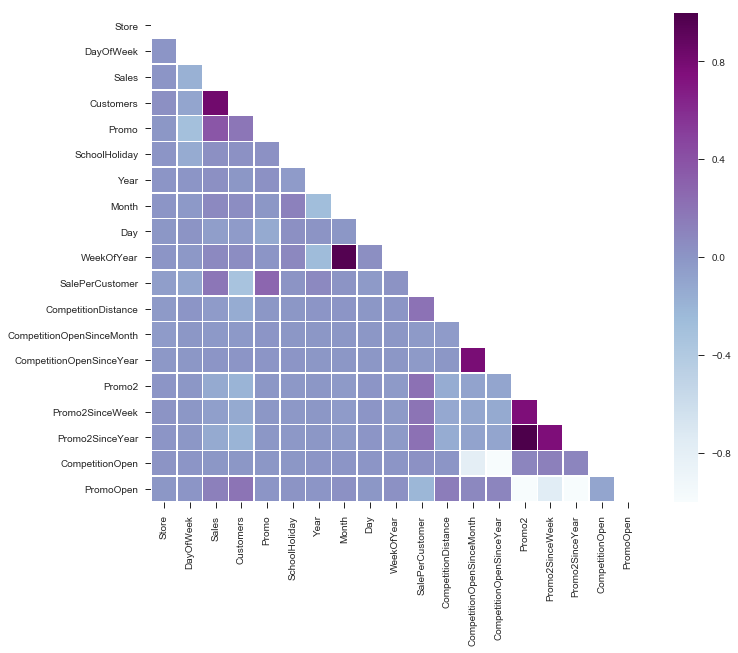

In [29]:
# compute the correlation matrix exclude 'Open' variable
corr_all = train_store.drop('Open',axis=1).corr()
# generate a mask for the upper triangle
mask = np.zeros_like(corr_all,dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# set up the matplotlib figure
f,ax = plt.subplots(figsize = (12,9))
# draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all,mask=mask,square = True, linewidths=.5,ax=ax,cmap='BuPu')
plt.show()

As mentioned before, we have a strong positive correlation between the amount of Sales and Customers of a store. We can also observe a positive correlation between the fact that the store had a running promotion (Promo equal to 1) and amount of Customers

However, when the store continues a consecutive promotion (Promo2 equal to 2) the number of Customers and Sales seems to stay the same or even decrease, which is described by the pale negative correlation on the heatmap. The same negative correlation is observed between the presence of the promotion in the store (Promo2SinceWeek)

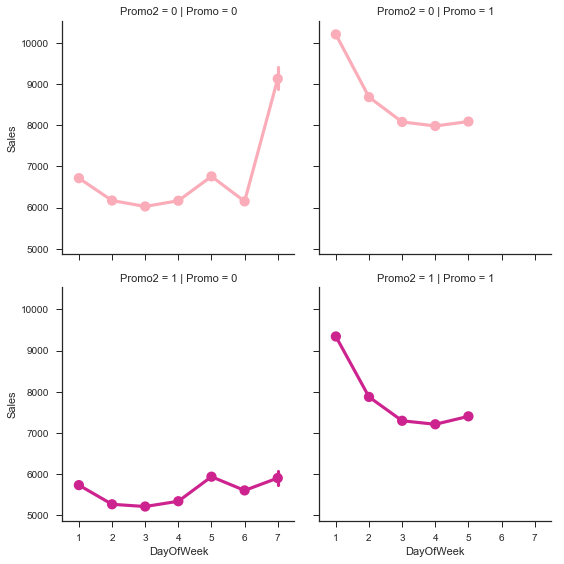

In [30]:
# sales trends between promo,promo2 and day of week
sns.factorplot(data = train_store, x='DayOfWeek',y = 'Sales',
              col = 'Promo',
              row = 'Promo2',
              hue = 'Promo2',
              palette = 'RdPu')

Several things here:

1. In case of no promotion, both promo and promo2 are equal to 0, Sales tend to peak on Sunday. Though we should note that Storetype C doesn't work on Sunday. So, it is mainly data from A,B and D
2. On the contrary, stores that run the promotion tent to make most of the Sales on **Monday**. This fact could be a good indicator for Rossmann marketing campaigns. The same trend follow the stores which have both promotion at the same time (promo and promo2 are equal to 1).
3. Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount, however, **it even decreases Sales**. This can be also proved by the blue pale area on the heatmap above.

## Conclusion of Analysis above

* The most selling and crowded StoreType is A.
* The best 'Sale per Customer' StoreType D indicates to the higher buyer cart. We could also assume that the stores of this types are situated in the rural areas, so that customers prefer buying more but less often.
* Low SalePerCustomer amount for StoreType B indicates to the possible fact that people shop there essentially for small things. Which can also indicate to the label of this store type URBAN as it's more accessible for public, and customers don't mind shopping there much time during a week.
* Customers tends to buy more on Mondays when there's one promotion running(Promo) and on Sunday when there is no promotion.
* Promo2 alone doesn't seem to be correlated to any significant change in the Sales amount

## Time-Series Analysis per StoreType

What makes a time series different from a regular regression problem?

1. It is time dependent. The basic assumption of a linear regression that the observations are independent doesn't hold in the case.
2. Along with an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame like Christmas holidays.
3. We build a time series analysis on storetypes instead of individual stores. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonaltities in the dataset.

In this section, we will analyse time series data: its trends, seasonalities and autocorrelation.

## Seasonality

We take four stores from storetypes to represent their group:

* number 2 store for type A
* number 85 store for type B
* number 1 store for type C
* number 13 store for type D

It also makes sense to downsample the data from days to weeks using the *resample* method to see the present trends more clearly.

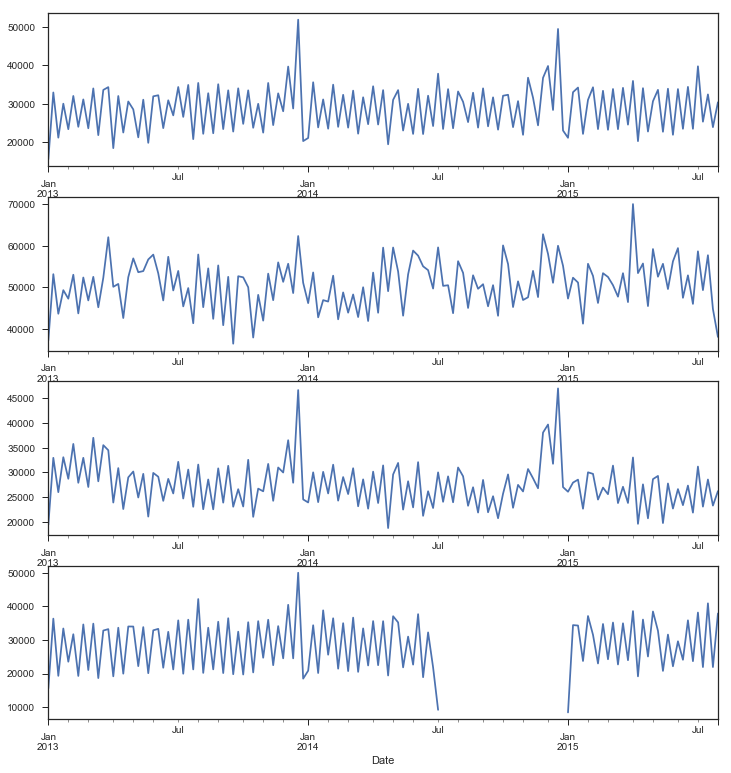

In [31]:
# input should be float type
train['Sales'] = train['Sales'] * 1.0

sales_a = train[train.Store == 2]['Sales']
sales_b = train[train.Store == 85]['Sales']#.sort_index(ascending = True) # solve the reverse order
sales_c = train[train.Store == 1]['Sales']
sales_d = train[train.Store == 13]['Sales']

f, (ax1,ax2,ax3,ax4) = plt.subplots(4, figsize = (12,13))

# store types
sales_a.resample('W').sum().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)

Retail sales for A and C tend to peak for the Christmas season and then decline after the holidays. We might have seen the same trend for D, but there is no information from July 2014 to Jan 2015 about this store as it was closed.

## Yearly Trend

The next thing to check the presence of a trend in series.

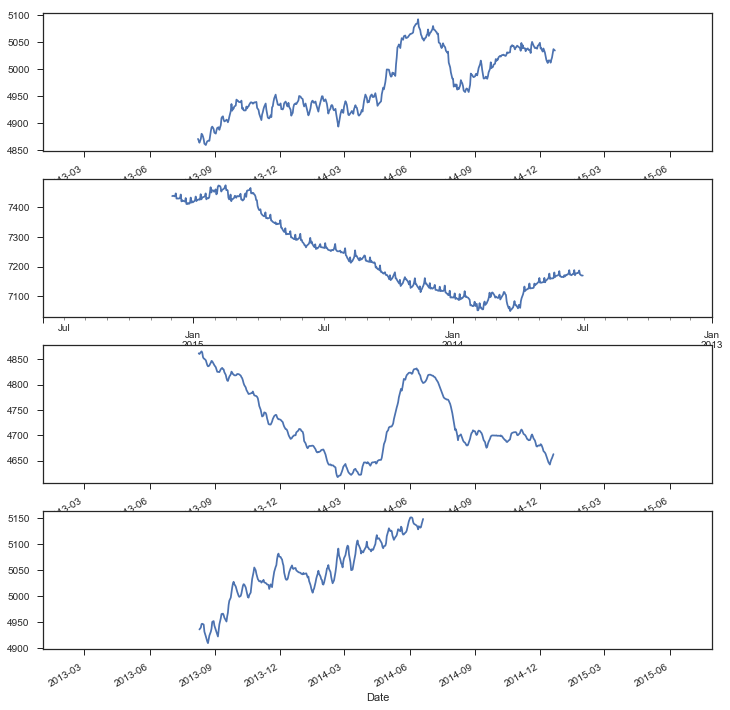

In [32]:
f, (ax1,ax2,ax3,ax4) = plt.subplots(4,figsize=(12,13))

# seasonal sales trend
decomposition_a = seasonal_decompose(sales_a,model = 'additive',freq = 365)
decomposition_a.trend.plot(ax = ax1)
decomposition_b = seasonal_decompose(sales_b,model = 'additive',freq = 365)
decomposition_b.trend.plot(ax = ax2)
decomposition_c = seasonal_decompose(sales_c,model = 'additive',freq = 365)
decomposition_c.trend.plot(ax = ax3)
decomposition_d = seasonal_decompose(sales_d,model = 'additive',freq = 365)
decomposition_d.trend.plot(ax = ax4)


Overall sales seems to increase, however not for the C. Eventhough the A is the most selling storetype in the dataset, it seems that it cab follow the same decreasing trajectory as C did.

## Autocorrelation

The next step in our time series analysis is to review Autocorrelation Function(ACF) and Partial Autocorrelation Function(PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag5, ACF would compare series at time instant 't1' ... 'tn' with series at instant 't1-5 ... tn-5' (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged verion of itself but after eliminationg the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

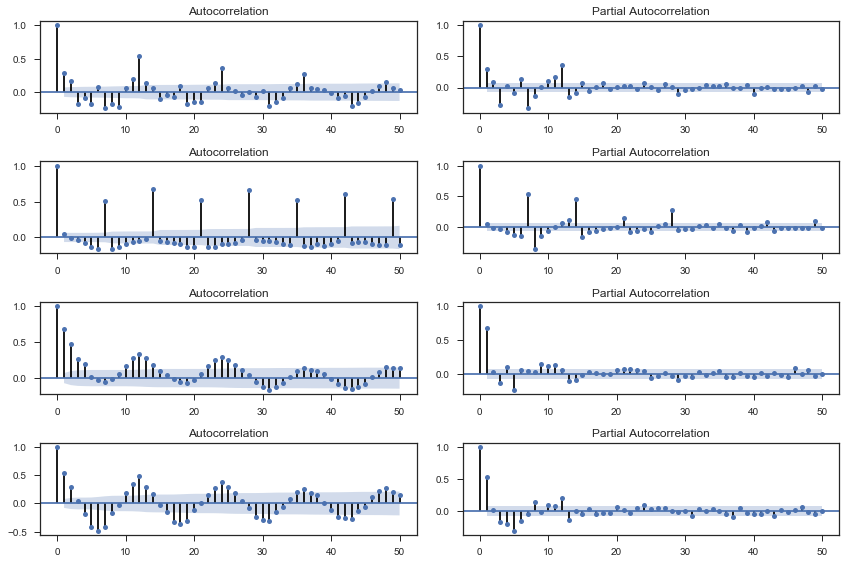

In [33]:
plt.figure(figsize = (12,8))
# acf and pacf for A
plt.subplot(421)
plot_acf(sales_a, lags = 50, ax=plt.gca())
plt.subplot(422)
plot_pacf(sales_a, lags = 50, ax=plt.gca())

# acf and pacf for B
plt.subplot(423)
plot_acf(sales_b, lags = 50, ax=plt.gca())
plt.subplot(424)
plot_pacf(sales_b, lags = 50, ax=plt.gca())

# acf and pacf for C
plt.subplot(425)
plot_acf(sales_c, lags = 50, ax=plt.gca())
plt.subplot(426)
plot_pacf(sales_c, lags = 50, ax=plt.gca())

# acf and pacf for D
plt.subplot(427)
plot_acf(sales_d, lags = 50, ax=plt.gca())
plt.subplot(428)
plot_pacf(sales_d, lags = 50, ax=plt.gca())
plt.tight_layout()
plt.show()

Each horizontal pair is for one type from A to D. In general, those plots are showing the correlation of the series with itself,lagged by x time units correlation of the series with itself, lagged by x time units.

There is at two things common for each pair of plots: non randomnes of the time series and high lag-1(which will probably need a higher order of differencing D).

* Type A and type B: Both types show seasonalities at certain lags. For type A, it is each 12th observation with positives spikes at the 12 (s) and 24(2s) lags and so on. For type B it's a weekly trend with positives spikes at the 7(s), 14(2s), 21(3s) and 28(4s) lags.
* Type C and type D: Plots of these two types are more complex. It seems like each observation is coorrelated to its adjacent observations.

## Next we will use Xgboost to predict

In [7]:
from sklearn.model_selection import train_test_split
import xgboost as xgb

In [3]:
def ToWeight(y):
    w = np.zeros(y.shape ,dtype=float)
    index = y != 0
    w[index] = 1./(y[index]**2)
    return w
def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return rmspe
def rmspe_xg(yhat,y):
    y = y.get_label()
    y = np.exp(y) -1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w*(y-yhat)**2))
    return "rmspe",rmspe

In [4]:
# extract feature
def extra_feature(features, data):
    data.fillna(0, inplace = True)
    # fill in missing value in Open feature
    data.loc[data.Open.isnull(), 'Open'] = 1
    features.extend(['Store','CompetitionDistance','CompetitionOpenSinceMonth',
                     'CompetitionOpenSinceYear','Promo','Promo2','Promo2SinceWeek',
                    'Promo2SinceYear'])
    # add some more features based on analysis from above
    features.append('SchoolHoliday')
    data['SchoolHoliday'] = data['SchoolHoliday'].astype(float)
    features.append('DayOfWeek')
    features.append('Month')
    features.append('Day')
    features.append('Year')
    data['Year'] = data.Date.apply(lambda x:x.split('-')[0]).astype(float)
    data['Month'] = data.Date.apply(lambda x:x.split('-')[1]).astype(float)
    data['Day'] = data.Date.apply(lambda x:x.split('-')[2]).astype(float)
    
    features.append('StoreType')
    data.loc[data['StoreType'] == 'a', 'StoreType'] = '1'
    data.loc[data['StoreType'] == 'b', 'StoreType'] = '2'
    data.loc[data['StoreType'] == 'c', 'StoreType'] = '3'
    data.loc[data['StoreType'] == 'd', 'StoreType'] = '4'
    data['StoreType'] = data['StoreType'].astype(float)
    
    features.append('Assortment')
    data.loc[data['Assortment'] == 'a', 'Assortment'] = '1'
    data.loc[data['Assortment'] == 'b', 'Assortment'] = '2'
    data.loc[data['Assortment'] == 'c', 'Assortment'] = '3'
    data['Assortment'] = data['Assortment'].astype(float)

In [8]:
print("Load the training, test and store data using pandas")
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
store = pd.read_csv("store.csv")

print("Assume store open, if not provided")
test.fillna(1, inplace=True)

print("Consider only open stores for training. Closed stores wont count into the score.")
train = train[train["Open"] != 0]

print("Join with store")
train = pd.merge(train, store, on='Store')
test = pd.merge(test, store, on='Store')

features = []

print("augment features")
extra_feature(features, train)
extra_feature([], test)
print(features)

#eta: Step size used in updating weights. Lower value means slower training but better convergence.
#num_round: Total number of iterations.
#subsample: The ratio of training data used in each iteration; combat overfitting. 
#Should be configured in the range of 30% to 80% of the training dataset, 
#and compared to a value of 100% for no sampling.
#colsample_bytree: The ratio of features used in each iteration, default 1.
#max_depth: The maximum depth of each tree. If we do not limit max depth, gradient boosting would eventually overfit.
#early_stopping_rounds: If there's no increase in validation score for a given number of iterations, the algorithm will stop early, also combats overfitting.
params = {"objective": "reg:linear", # regression task
          "eta": 0.3,
          "max_depth": 8,
          "subsample": 0.7, # 70% of data to grow trees and prevent overfitting
          "colsample_bytree": 0.7,
          "silent": 1,
          'seed': 42  # guarantee reproducible results
          }
num_trees = 300

print("Train a XGBoost model")
val_size = 100000
print(train.tail(1)['Date'])
X_train, X_test = train_test_split(train, test_size=0.01)
dtrain = xgb.DMatrix(X_train[features], np.log(X_train["Sales"] + 1))
dvalid = xgb.DMatrix(X_test[features], np.log(X_test["Sales"] + 1))
dtest = xgb.DMatrix(test[features])
watchlist = [(dvalid, 'eval'), (dtrain, 'train')]
gbm = xgb.train(params, dtrain, num_trees, evals=watchlist, 
                early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

print("Validating")
train_probs = gbm.predict(xgb.DMatrix(X_test[features]))
indices = train_probs < 0
train_probs[indices] = 0
error = rmspe(np.exp(train_probs) - 1, X_test['Sales'].values)
print('error', error)

print("Make predictions on the test set")
test_probs = gbm.predict(xgb.DMatrix(test[features]))
indices = test_probs < 0
test_probs[indices] = 0
submission = pd.DataFrame({"Id": test["Id"], "Sales": np.exp(test_probs) - 1})
submission.to_csv("xgboost_kscript_submission.csv", index=False)

Load the training, test and store data using pandas
Assume store open, if not provided
Consider only open stores for training. Closed stores wont count into the score.
Join with store
augment features
['Store', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'SchoolHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'StoreType', 'Assortment']
Train a XGBoost model
844391    2013-01-02
Name: Date, dtype: object
[0]	eval-rmse:5.79716	train-rmse:5.79362	eval-rmspe:0.996792	train-rmspe:0.99681
Multiple eval metrics have been passed: 'train-rmspe' will be used for early stopping.

Will train until train-rmspe hasn't improved in 50 rounds.
[1]	eval-rmse:4.06685	train-rmse:4.06292	eval-rmspe:0.981558	train-rmspe:0.981518
[2]	eval-rmse:2.85851	train-rmse:2.85452	eval-rmspe:0.938133	train-rmspe:0.937965
[3]	eval-rmse:2.01647	train-rmse:2.01201	eval-rmspe:0.856703	train-rmspe:0.856354
[4]	eval-rmse:1.43238	train-

[90]	eval-rmse:0.152429	train-rmse:0.140096	eval-rmspe:0.128288	train-rmspe:0.190963
[91]	eval-rmse:0.152023	train-rmse:0.139597	eval-rmspe:0.127772	train-rmspe:0.190586
[92]	eval-rmse:0.151912	train-rmse:0.139427	eval-rmspe:0.127626	train-rmspe:0.190473
[93]	eval-rmse:0.151563	train-rmse:0.139077	eval-rmspe:0.127188	train-rmspe:0.190224
[94]	eval-rmse:0.151341	train-rmse:0.138514	eval-rmspe:0.126948	train-rmspe:0.189659
[95]	eval-rmse:0.151047	train-rmse:0.138106	eval-rmspe:0.126565	train-rmspe:0.18917
[96]	eval-rmse:0.150771	train-rmse:0.137748	eval-rmspe:0.126237	train-rmspe:0.188826
[97]	eval-rmse:0.150532	train-rmse:0.137444	eval-rmspe:0.125913	train-rmspe:0.187848
[98]	eval-rmse:0.150367	train-rmse:0.137213	eval-rmspe:0.125728	train-rmspe:0.180557
[99]	eval-rmse:0.149928	train-rmse:0.136714	eval-rmspe:0.125077	train-rmspe:0.179868
[100]	eval-rmse:0.149593	train-rmse:0.136328	eval-rmspe:0.124686	train-rmspe:0.179215
[101]	eval-rmse:0.149478	train-rmse:0.136038	eval-rmspe:0.124431	

[186]	eval-rmse:0.139931	train-rmse:0.120805	eval-rmspe:0.110455	train-rmspe:0.159874
[187]	eval-rmse:0.1399	train-rmse:0.120759	eval-rmspe:0.110412	train-rmspe:0.159743
[188]	eval-rmse:0.139868	train-rmse:0.120684	eval-rmspe:0.110391	train-rmspe:0.1597
[189]	eval-rmse:0.139745	train-rmse:0.120548	eval-rmspe:0.110279	train-rmspe:0.159573
[190]	eval-rmse:0.13962	train-rmse:0.1204	eval-rmspe:0.110117	train-rmspe:0.159351
[191]	eval-rmse:0.139449	train-rmse:0.120238	eval-rmspe:0.109887	train-rmspe:0.159178
[192]	eval-rmse:0.139457	train-rmse:0.120187	eval-rmspe:0.10989	train-rmspe:0.159129
[193]	eval-rmse:0.139359	train-rmse:0.120074	eval-rmspe:0.109771	train-rmspe:0.159008
[194]	eval-rmse:0.139319	train-rmse:0.120026	eval-rmspe:0.109701	train-rmspe:0.158971
[195]	eval-rmse:0.139283	train-rmse:0.119987	eval-rmspe:0.109669	train-rmspe:0.158953
[196]	eval-rmse:0.139205	train-rmse:0.119708	eval-rmspe:0.109636	train-rmspe:0.158907
[197]	eval-rmse:0.139139	train-rmse:0.119601	eval-rmspe:0.1095

[282]	eval-rmse:0.135656	train-rmse:0.11137	eval-rmspe:0.103836	train-rmspe:0.145155
[283]	eval-rmse:0.135612	train-rmse:0.111289	eval-rmspe:0.103747	train-rmspe:0.145208
[284]	eval-rmse:0.135538	train-rmse:0.111175	eval-rmspe:0.103697	train-rmspe:0.145128
[285]	eval-rmse:0.135519	train-rmse:0.111128	eval-rmspe:0.103663	train-rmspe:0.145113
[286]	eval-rmse:0.135439	train-rmse:0.111055	eval-rmspe:0.103622	train-rmspe:0.145476
[287]	eval-rmse:0.135431	train-rmse:0.110994	eval-rmspe:0.103603	train-rmspe:0.145444
[288]	eval-rmse:0.135417	train-rmse:0.110903	eval-rmspe:0.103561	train-rmspe:0.145544
[289]	eval-rmse:0.13541	train-rmse:0.110835	eval-rmspe:0.103559	train-rmspe:0.145392
[290]	eval-rmse:0.135377	train-rmse:0.110791	eval-rmspe:0.103509	train-rmspe:0.145351
[291]	eval-rmse:0.135361	train-rmse:0.110749	eval-rmspe:0.103489	train-rmspe:0.145312
[292]	eval-rmse:0.135365	train-rmse:0.110663	eval-rmspe:0.103491	train-rmspe:0.145144
[293]	eval-rmse:0.135333	train-rmse:0.110576	eval-rmspe:

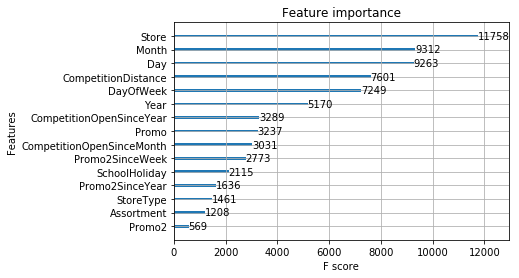

In [12]:
from xgboost import plot_importance
plot_importance(gbm)